## Mall Customer Segmentation with Clustering

### Step 1: Setup and load dataset

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import os

In [2]:
# Load the Dataset

os.environ['KAGGLE_USERNAME'] = "niranjanappaji"
os.environ['KAGGLE_KEY'] = "f969ecf53c07caf0b0ee95cf11175917"

!kaggle datasets download -d amisha0528/mall-customers-dataset --unzip

df = pd.read_csv('Mall_Customers.csv')

Dataset URL: https://www.kaggle.com/datasets/amisha0528/mall-customers-dataset
License(s): apache-2.0
  0%|                                               | 0.00/1.56k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 1.56k/1.56k [00:00<00:00, 1.23MB/s]


In [3]:
print("First 5 rows:")
df.head()

First 5 rows:


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
print("Dataset Info:\n")
df.info()

Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [5]:
print("Dataset Description:")
df.describe()

Dataset Description:


,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


**Insight:** The dataset contains 200 customer records with features like Age, Annual Income, and Spending Score. There are no missing values, and the data types are appropriate.

### Step 2: Exploratory Data Analysis

In [6]:
# Drop CustomerID column as it is irrelevant for clustering

df = df.drop("CustomerID", axis = 1)
df.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


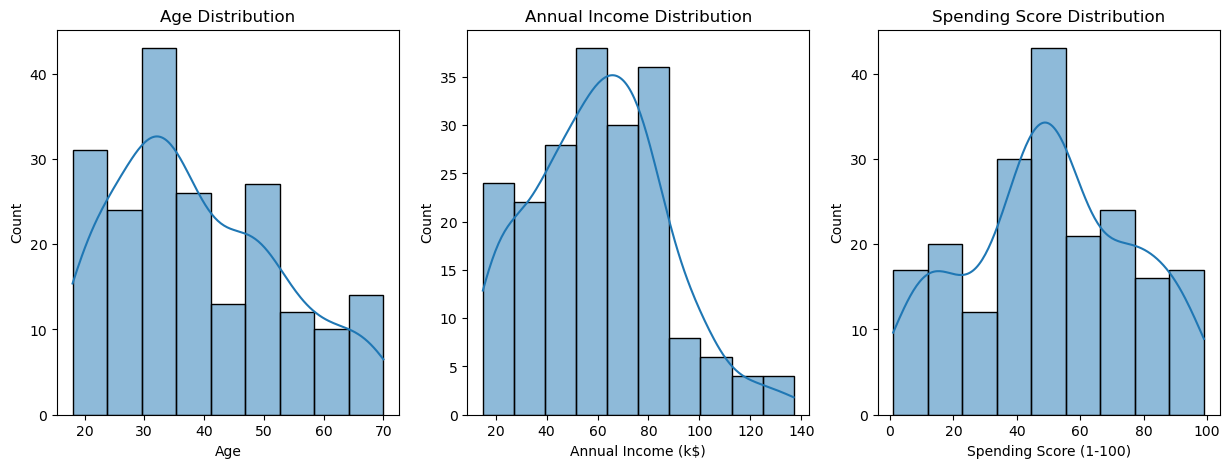

In [7]:
# Visualize distributions

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(df["Age"], kde=True)
plt.title("Age Distribution")
plt.subplot(1, 3, 2)
sns.histplot(df["Annual Income (k$)"], kde=True)
plt.title("Annual Income Distribution")
plt.subplot(1, 3, 3)
sns.histplot(df["Spending Score (1-100)"], kde=True)
plt.title("Spending Score Distribution")
plt.show()

/Users/niranjanappaji/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


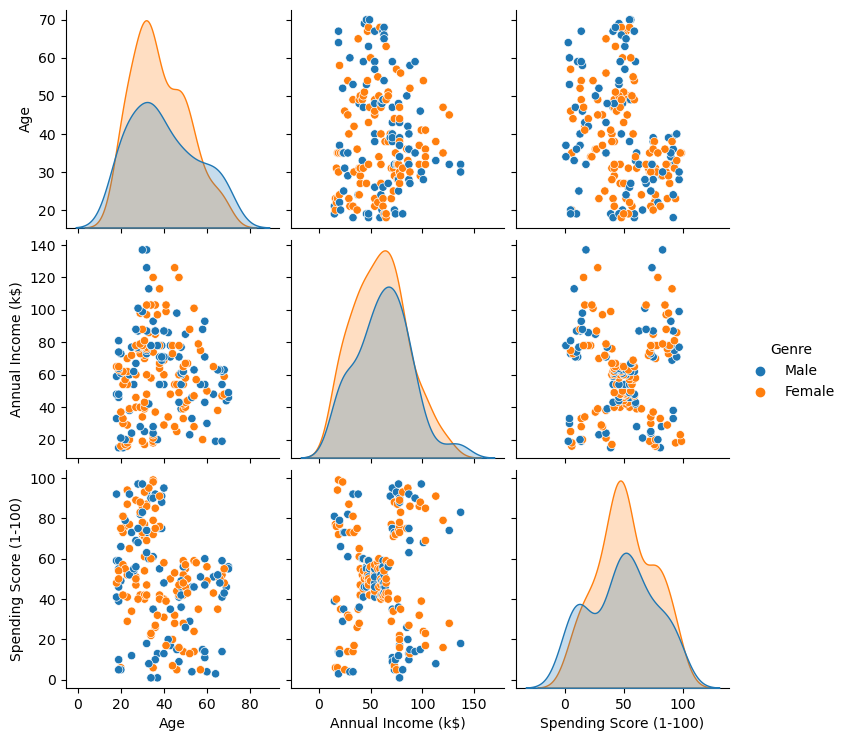

In [8]:
sns.pairplot(df, hue="Genre")
plt.show()

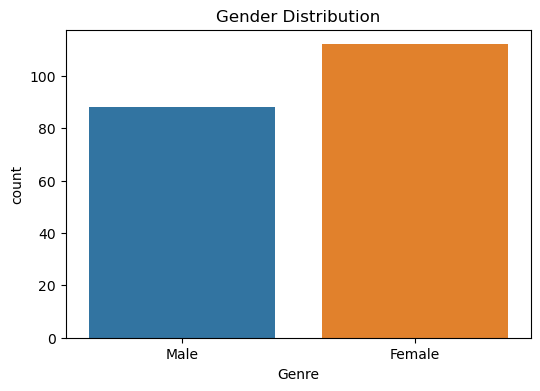

In [9]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Genre', data=df)
plt.title('Gender Distribution')
plt.show()

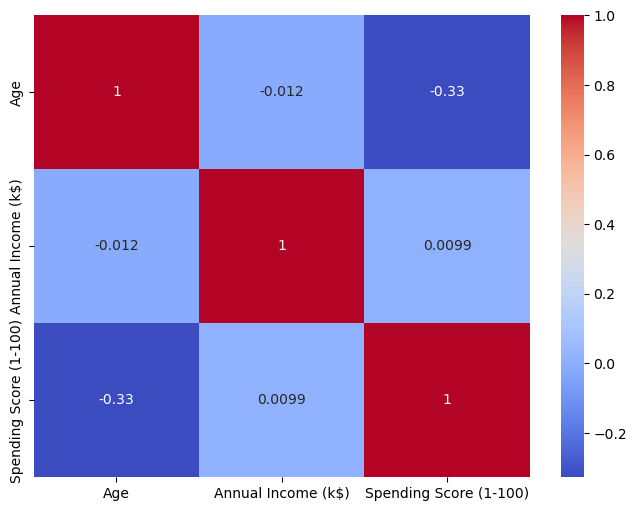

In [10]:
# Correlation Matrix

plt.figure(figsize= (8, 6))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap = "coolwarm")
plt.show()

**Insight:**
* Age is relatively normally distributed.
* Annual Income has a bimodal distribution, suggesting potential customer segments.
* Spending Score is relatively uniformly distributed.
* There's no strong linear correlation between features.
* The pairplot reveals potential patterns in spending score and income, which are important for customer segmentation.
* There is a relatively even gender distribution.

### Step 3: Data Processing

In [11]:
# Convert Gender field to numeric values

df["Genre"] = df["Genre"].map({"Male":1, "Female":0})
df.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40


In [12]:
# Scale the data

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
df_scaled = pd.DataFrame(scaled_data, columns = df.columns)

In [13]:
df_scaled.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1.128152,-1.424569,-1.738999,-0.434801
1,1.128152,-1.281035,-1.738999,1.195704
2,-0.886405,-1.352802,-1.700830,-1.715913
3,-0.886405,-1.137502,-1.700830,1.040418
4,-0.886405,-0.563369,-1.662660,-0.395980


In [14]:
df.describe()

,Genre,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,0.440000,38.850000,60.560000,50.200000
std,0.497633,13.969007,26.264721,25.823522
min,0.000000,18.000000,15.000000,1.000000
25%,0.000000,28.750000,41.500000,34.750000
50%,0.000000,36.000000,61.500000,50.000000
75%,1.000000,49.000000,78.000000,73.000000
max,1.000000,70.000000,137.000000,99.000000


In [15]:
df_scaled.describe()

,Genre,Age,Annual Income (k$),Spending Score (1-100)
count,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02
mean,3.108624e-17,-1.021405e-16,-2.131628e-16,-1.465494e-16
std,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00
min,-8.864053e-01,-1.496335e+00,-1.738999e+00,-1.910021e+00
25%,-8.864053e-01,-7.248436e-01,-7.275093e-01,-5.997931e-01
50%,-8.864053e-01,-2.045351e-01,3.587926e-02,-7.764312e-03
75%,1.128152e+00,7.284319e-01,6.656748e-01,8.851316e-01
max,1.128152e+00,2.235532e+00,2.917671e+00,1.894492e+00


**Insight:** Scaling the data ensures that all features contribute equally to the distance calculations in the clustering algorithms.

### Step 4: K-Means Clustering

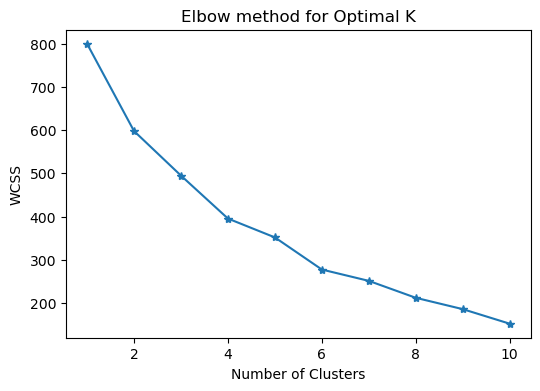

In [16]:
# Finding optimal K using the Elbow method

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init="auto")
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)
    
plt.figure(figsize=(6, 4))
plt.plot(range(1, 11), wcss, marker='*')
plt.title("Elbow method for Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

In [33]:
# Apply K-Means with optimal K (let's assume 5 from the elbow method)

kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
df["KMeans_Cluster"] = kmeans.fit_predict(df_scaled)


In [34]:
df.head(10)


,Genre,Age,Annual Income (k$),Spending Score (1-100),KMeans_Cluster,DBSCAN_Cluster,Agg_Cluster
0,1,19,15,39,2,-1,0
1,1,21,15,81,2,-1,0
2,0,20,16,6,4,-1,3
3,0,23,16,77,4,0,0
4,0,31,17,40,4,-1,3
5,0,22,17,76,4,0,0
6,0,35,18,6,4,-1,3
7,0,23,18,94,4,-1,0
8,1,64,19,3,0,-1,4
9,0,30,19,72,4,0,0


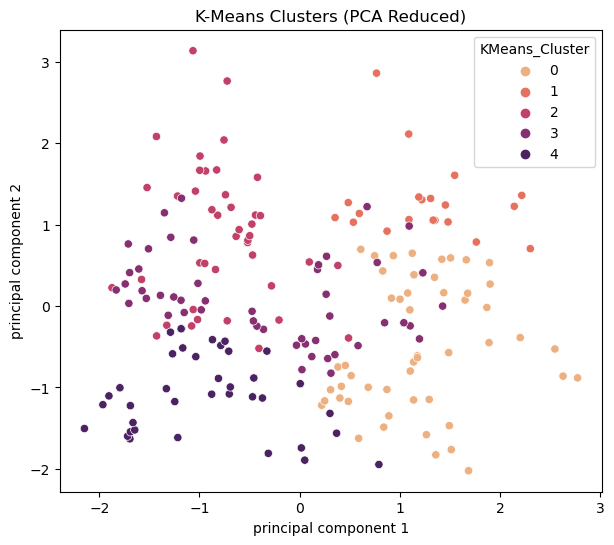

In [35]:
pca = PCA(n_components = 2)
pca_data = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(pca_data, columns = ['principal component 1', 'principal component 2'])
df_pca['KMeans_Cluster'] = df['KMeans_Cluster']

plt.figure(figsize=(7, 6))
sns.scatterplot(x='principal component 1', y='principal component 2', hue='KMeans_Cluster', data=df_pca, palette='flare')
plt.title('K-Means Clusters (PCA Reduced)')
plt.show()


In [36]:
print("K-Means silhouette score:", silhouette_score(df_scaled, df['KMeans_Cluster']))
print("K-Means Calinski Harabasz score:", calinski_harabasz_score(df_scaled, df['KMeans_Cluster']))

K-Means silhouette score: 0.27191023466188324
K-Means Calinski Harabasz score: 62.12634193286723


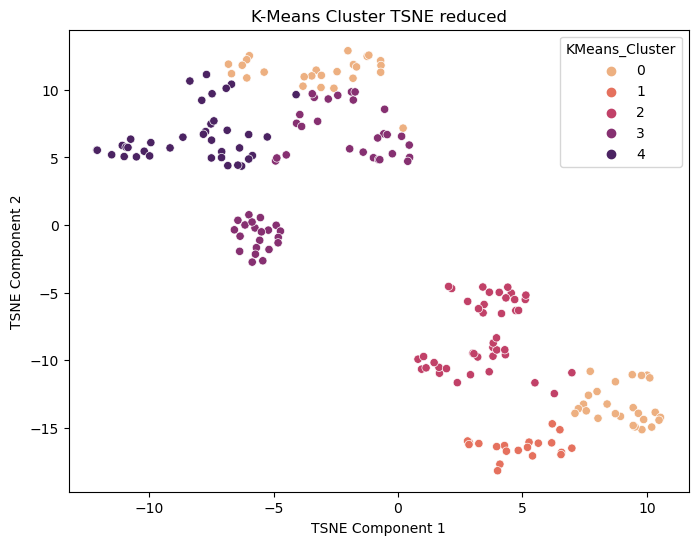

In [37]:
# t-SNE dimensionality reduction and visualization

from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, random_state=42, perplexity=30)
tsne_data = tsne.fit_transform(df_scaled)
tsne_df = pd.DataFrame(data = tsne_data, columns =['TSNE Component 1', 'TSNE Component 2'])
tsne_df['KMeans_Cluster'] = df['KMeans_Cluster']

plt.figure(figsize=(8, 6))
sns.scatterplot(x='TSNE Component 1', y='TSNE Component 2', hue='KMeans_Cluster', data=tsne_df, palette='flare')
plt.title('K-Means Cluster TSNE reduced')
plt.show()

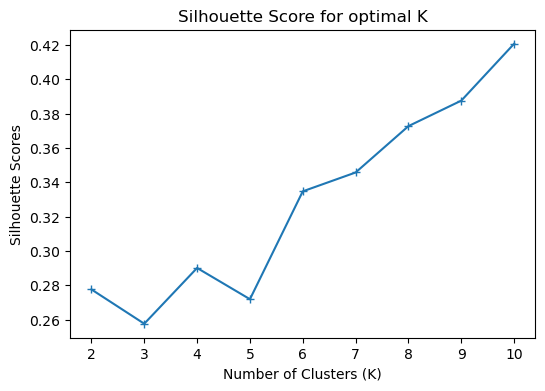

In [22]:
# Silhouette Score

silhouette_scores = []
for i in range(2, 11): # silhouette score requires at least 2 clusters
    kmeans = KMeans(n_clusters = i, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(df_scaled)
    silhouette_scores.append(silhouette_score(df_scaled, labels))
    
plt.figure(figsize=(6, 4))
plt.plot(range(2, 11), silhouette_scores, marker = '+')
plt.title('Silhouette Score for optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Scores')
plt.show()


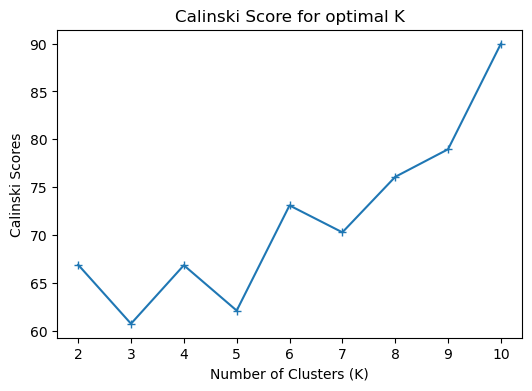

In [23]:
# Calinski Score

calinski_score = []
for i in range(2, 11): # calinski harabasz score requires at least 2 clusters
    kmeans = KMeans(n_clusters = i, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(df_scaled)
    calinski_score.append(calinski_harabasz_score(df_scaled, labels))
    
plt.figure(figsize=(6, 4))
plt.plot(range(2, 11), calinski_score, marker = '+')
plt.title('Calinski Score for optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Calinski Scores')
plt.show()

### Step 5 - DBSCAN Clustering

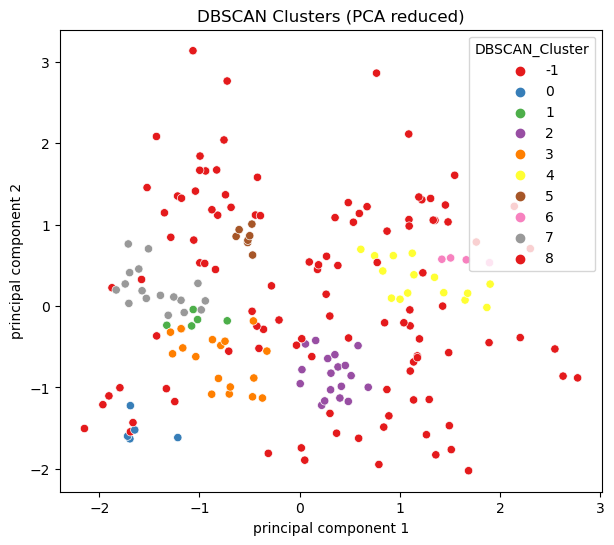

In [24]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['DBSCAN_Cluster'] = dbscan.fit_predict(df_scaled)

df_pca['DBSCAN_Cluster'] = df['DBSCAN_Cluster']

plt.figure(figsize=(7, 6))
sns.scatterplot(x='principal component 1', y='principal component 2', hue='DBSCAN_Cluster', data=df_pca, palette="Set1")
plt.title('DBSCAN Clusters (PCA reduced)')
plt.show()

In [25]:
# Evaluate DBSCAN Clustering

print("DBSCAN Silhouette Score:", silhouette_score(df_scaled, df['DBSCAN_Cluster']))
print("DBSCAN Calinski Harabasz Score:", calinski_harabasz_score(df_scaled, df['DBSCAN_Cluster']))


DBSCAN Silhouette Score: 0.012015057781900538
DBSCAN Calinski Harabasz Score: 12.099397092470902


**Insight:**
* DBSCAN identified a large number of outliers (-1 label).
* DBSCAN did not create well defined clusters for this dataset.
* The Scores show poor performance for DBSCAN.

### Step 6 - Agglomerative Clustering

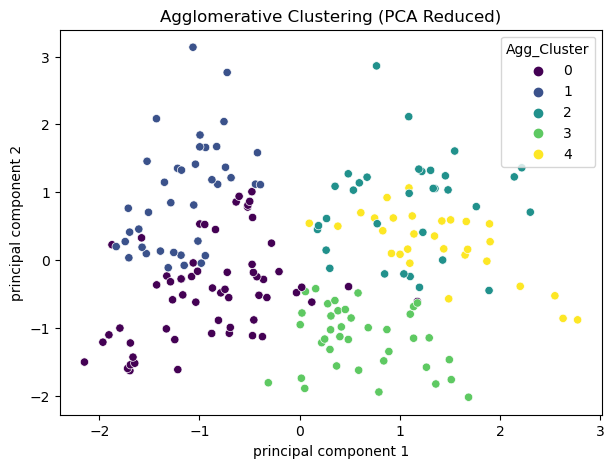

In [26]:
agg_clustering = AgglomerativeClustering(n_clusters = 5)
df["Agg_Cluster"] = agg_clustering.fit_predict(df_scaled)

df_pca["Agg_Cluster"] = df["Agg_Cluster"]

plt.figure(figsize=(7, 5))
sns.scatterplot(x='principal component 1', y='principal component 2', hue='Agg_Cluster', data=df_pca, palette='viridis')
plt.title('Agglomerative Clustering (PCA Reduced)')
plt.show()

In [27]:
# Evaluate Agglomerative Clustering

print("Agglomerative Silhouette Score:", silhouette_score(df_scaled, df['Agg_Cluster']))
print("Agglomerative Calinski Harabasz score:", calinski_harabasz_score(df_scaled, df['Agg_Cluster']))

Agglomerative Silhouette Score: 0.28699413201651747
Agglomerative Calinski Harabasz score: 64.46870730105833


### Step 7 - Explainability

In [28]:
# Cluster Profiles (K-Means)

kmeans_clusters = df.groupby("KMeans_Cluster").mean()
print("\nK-Means Cluster Profiles:\n", kmeans_clusters)


K-Means Cluster Profiles:
                    Genre        Age  Annual Income (k$)  \
KMeans_Cluster                                            
0               0.433333  54.700000           46.900000   
1               0.588235  41.264706           88.500000   
2               1.000000  28.690476           60.904762   
3               0.000000  29.375000           58.296875   

                Spending Score (1-100)  DBSCAN_Cluster  Agg_Cluster  
KMeans_Cluster                                                       
0                            39.933333        1.516667     3.350000  
1                            16.764706       -1.000000     2.117647  
2                            70.238095        1.523810     0.619048  
3                            64.437500        2.421875     0.562500  


In [29]:
# Cluster Profiles (DBSCAN)

DBSCAN_clusters = df.groupby("DBSCAN_Cluster").mean()
print("\n DBSCAN Cluster profiles:\n", DBSCAN_clusters)


 DBSCAN Cluster profiles:
                    Genre        Age  Annual Income (k$)  \
DBSCAN_Cluster                                            
-1              0.485714  39.314286           63.580952   
 0              0.000000  24.000000           20.400000   
 1              1.000000  25.400000           23.600000   
 2              0.000000  49.722222           53.388889   
 3              0.000000  25.444444           53.888889   
 4              1.000000  57.400000           52.066667   
 5              1.000000  22.857143           61.000000   
 6              1.000000  66.500000           62.750000   
 7              0.000000  31.470588           80.470588   
 8              1.000000  36.666667           76.333333   

                Spending Score (1-100)  KMeans_Cluster  Agg_Cluster  
DBSCAN_Cluster                                                       
-1                           40.847619        1.409524     1.733333  
 0                           75.000000        3.00000

In [30]:
# Cluster Profiles (DBSCAN)

Agg_clusters = df.groupby("Agg_Cluster").mean()
print("\n Agglomerative Cluster profiles:\n", Agg_clusters)


 Agglomerative Cluster profiles:
                 Genre        Age  Annual Income (k$)  Spending Score (1-100)  \
Agg_Cluster                                                                    
0            0.377049  26.147541           43.770492               58.967213   
1            0.461538  32.692308           86.538462               82.128205   
2            0.545455  41.454545           89.090909               16.181818   
3            0.000000  49.789474           44.105263               39.657895   
4            1.000000  56.551724           50.034483               41.344828   

             KMeans_Cluster  DBSCAN_Cluster  
Agg_Cluster                                  
0                  2.590164        1.114754  
1                  2.538462        3.871795  
2                  0.969697       -1.000000  
3                  0.394737        0.421053  
4                  0.206897        2.551724  


In [31]:
kmeans_clusters

,Genre,Age,Annual Income (k$),Spending Score (1-100),DBSCAN_Cluster,Agg_Cluster
KMeans_Cluster,,,,,,
0,0.433333,54.700000,46.900000,39.933333,1.516667,3.350000
1,0.588235,41.264706,88.500000,16.764706,-1.000000,2.117647
2,1.000000,28.690476,60.904762,70.238095,1.523810,0.619048
3,0.000000,29.375000,58.296875,64.437500,2.421875,0.562500


Text(0.5, 1.0, 'K Means Age per cluster')

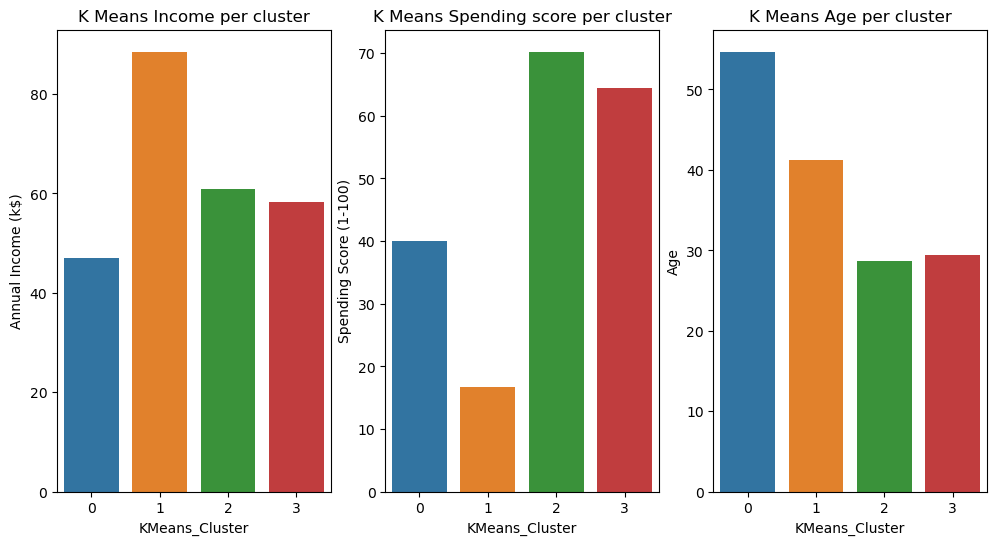

In [32]:
# Visualisation of cluster profiles

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.barplot(x = kmeans_clusters.index, y = kmeans_clusters['Annual Income (k$)'])
plt.title('K Means Income per cluster')

plt.subplot(1, 3, 2)
sns.barplot(x = kmeans_clusters.index, y = kmeans_clusters['Spending Score (1-100)'])
plt.title('K Means Spending score per cluster')

plt.subplot(1, 3, 3)
sns.barplot(x = kmeans_clusters.index, y = kmeans_clusters['Age'])
plt.title('K Means Age per cluster')

**Explanation:**

**EDA:** We visualized the distributions of key features and their relationships, revealing insights into customer behavior.

**Preprocessing:** We scaled the data to ensure that all features contribute equally to the clustering process.

**Clustering:** We applied K-Means, DBSCAN, and Agglomerative Clustering, visualizing the results using PCA for dimensionality reduction.

**Evaluation:** We used Silhouette Score and Calinski-Harabasz Score to assess the quality of the clusters.

**Explainability:** By analyzing the mean values of each feature within each cluster, we can understand the characteristics of each customer segment. For example, some clusters may represent high-income, high-spending customers, while others may represent low-income, low-spending customers.

**Visualization of Cluster Profiles:** Bar charts are used to compare the means of annual income, spending score, and age between the clusters generated by the K

### Explainability using Decision Tree

Decision Tree Accuracy on Test Set: 0.87


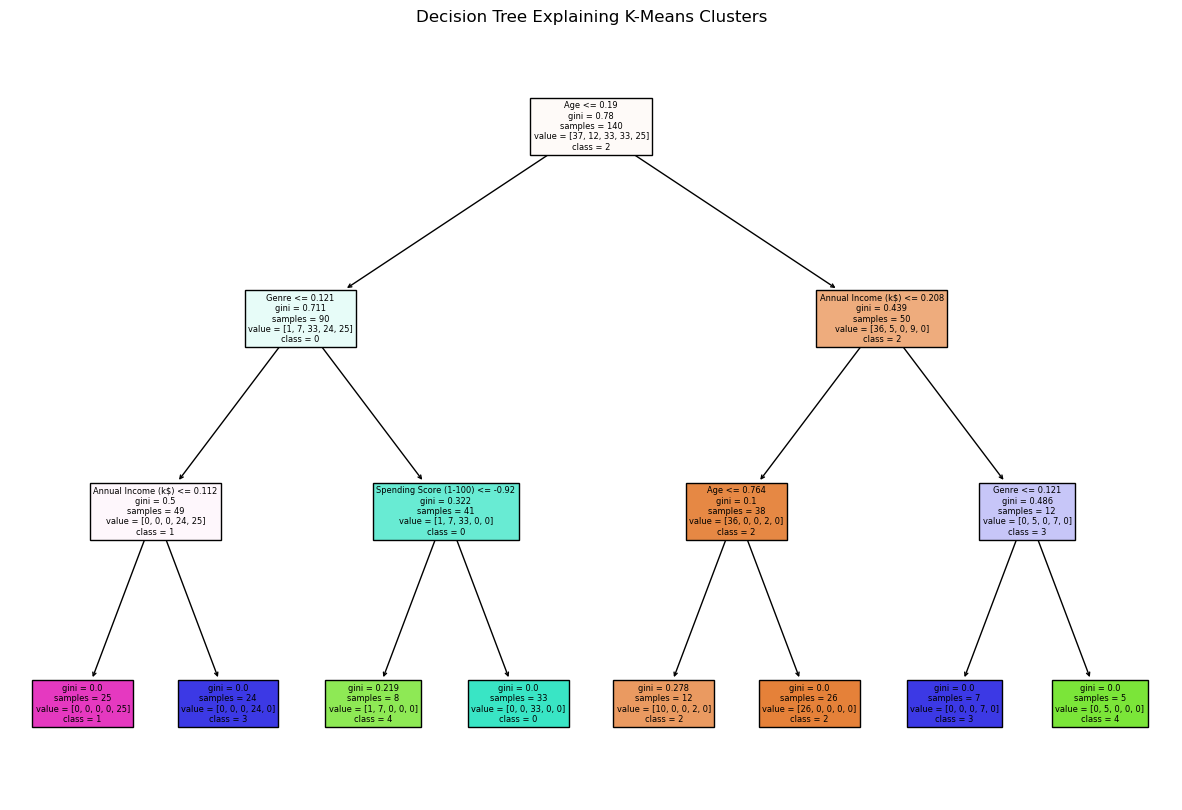


Feature Importances from Decision Tree:
 Annual Income (k$)        0.353806
Genre                     0.308623
Age                       0.227380
Spending Score (1-100)    0.110190
dtype: float64


In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree

# Prepare data for decision tree
X_explain = df_scaled  # Use scaled features for consistency, or original if desired
y_explain = df['KMeans_Cluster']

# Split data (optional, but good practice for evaluating tree performance)
X_train_explain, X_test_explain, y_train_explain, y_test_explain = train_test_split(
    X_explain, y_explain, test_size=0.3, random_state=42
)

# Train a Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42, max_depth=3) # Limit depth for better interpretability
dt_classifier.fit(X_train_explain, y_train_explain)

# Make predictions on the test set
y_pred_explain = dt_classifier.predict(X_test_explain)
accuracy = accuracy_score(y_test_explain, y_pred_explain)
print(f"Decision Tree Accuracy on Test Set: {accuracy:.2f}")

# Visualize the Decision Tree
plt.figure(figsize=(15, 10))
plot_tree(dt_classifier, filled=True, feature_names=X_explain.columns, class_names=y_explain.unique().astype(str))
plt.title("Decision Tree Explaining K-Means Clusters")
plt.show()

# Feature Importance from Decision Tree
feature_importances = pd.Series(dt_classifier.feature_importances_, index=X_explain.columns)
print("\nFeature Importances from Decision Tree:\n", feature_importances.sort_values(ascending=False))